In [19]:
%matplotlib inline
import numpy as np
from scipy.io import wavfile
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from IPython.core.display import HTML, display
import os,time

import theano
import theano.tensor as T

import lasagne
import random
from sklearn.ensemble import ExtraTreesClassifier

In [20]:
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

128
257


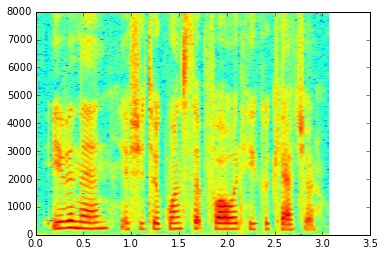

(257, 128)

In [21]:
[framerate,sound]=wavfile.read("SI1027_.wav")
#(spectrum, freqs, t, im)=specgram(sound,NFFT=256,Fs=256)
#print(np.max(spectrum))
(spectrum, freqs, t, im)=specgram(sound,NFFT=512,Fs=16000)
print(len(t))
print(len(freqs))
#print(np.max(spectrum))
plt.show()
wavPlayer("SI1027_.wav")
np.shape(spectrum)

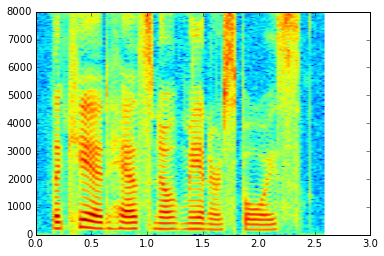

(257, 108)
(129, 100)


In [22]:
[framerate,sound]=wavfile.read("SI2048_.wav")
(spectrum, freqs, t, im)=specgram(sound,NFFT=512,Fs=16000)
plt.show()
wavPlayer("SI2048_.wav")
print(np.shape(spectrum))
print(np.shape(spectrum[:129,:100]))


In [23]:
def findData():
    print("finding files")
    inputFilesTrain = []
    targetTrain = []
    basePath =  os.getcwd()+"\\timit\\timit\\train"
    for path, subdirs, files in os.walk(basePath):
        print(".",end="")
        for name in files:
             if (name[-5:]=="_.WAV"):
                loc="\\".join((path,name))
                inputFilesTrain.append(loc)
                split=loc.split("\\")
                if split[-2][0]=="m":
                    targetTrain.append(1)
                elif split[-2][0]=="f":
                    targetTrain.append(0)
                else:
                    print(split)
                    raise ValueError("something fishy is going on")
    
    inputFilesTest = []
    targetTest = []
    basePath =  os.getcwd()+"\\timit\\timit\\test"
    for path, subdirs, files in os.walk(basePath):
        print(".",end="")
        for name in files:
             if (name[-5:]=="_.WAV"):
                loc="\\".join((path,name))
                inputFilesTest.append(loc)
                split=loc.split("\\")
                if split[-2][0]=="m":
                    targetTest.append(1)
                elif split[-2][0]=="f":
                    targetTest.append(0)
                else:
                    print(split)
                    raise ValueError("something fishy is going on")
                
                
    print("found {0} files".format(len(targetTrain)+len(targetTest)))
    return [(inputFilesTrain,targetTrain),(inputFilesTest,targetTest)]

In [24]:
def loadData(files,targets):
    print("loading data. Reporting progres...")
    n=len(files)
    numTimeSteps=150
    nFreqs=129
    X=np.empty((n,1,nFreqs,numTimeSteps))
    y=np.array(targets,dtype=int).reshape(-1,1)
    for i,elem in enumerate(files):
        if i % (int(n/10))==0:
            print(i/float(n))
        [framerate,sound]=wavfile.read(elem)
        [f,t,sxx]=ss.spectrogram(sound,fs=16000,nperseg=256,noverlap=192)#noverlap=128
        xvals=sxx[:,:numTimeSteps]
        X[i,:,:]=xvals/np.linalg.norm(xvals,'fro')
        #normalise 
    print("done")
    return X,y

In [25]:
[f,t,sxx] = ss.spectrogram(sound,fs=16000,nperseg=256,noverlap=192)
xvals = sxx[:,:80]
print(xvals/np.linalg.norm(xvals,'fro'))


[[  3.14035487e-09   5.74163916e-09   1.01043796e-09 ...,   3.43955886e-09
    6.30371233e-06   1.88340876e-09]
 [  1.72743540e-07   3.24165796e-08   8.10444547e-08 ...,   5.41316695e-06
    6.04045408e-06   7.50132604e-05]
 [  2.26000125e-08   6.54713928e-09   1.17019692e-08 ...,   2.29787056e-05
    1.50322858e-05   6.48633068e-05]
 ..., 
 [  4.08754541e-09   5.47827161e-09   6.31056940e-09 ...,   1.13052590e-06
    9.29016460e-06   1.14041286e-05]
 [  2.53231813e-09   5.86427884e-09   5.43022649e-09 ...,   2.98574037e-06
    2.38602888e-06   7.94535936e-06]
 [  2.28514474e-09   1.76149684e-09   2.11859219e-09 ...,   6.36982023e-08
    3.38353357e-06   1.02287436e-06]]


In [26]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [27]:
[f,t,sxx]=ss.spectrogram(sound,fs=16000,nfft=512)

In [28]:
len(f),len(t),sxx.shape

(257, 185, (257, 185))

In [29]:
[(filesTrain,fileTargetsTrain),(filesTest,fileTargetsTest)]=findData()

finding files
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................found 6300 files


In [30]:
print("train")
[X_train,y_train]=loadData(filesTrain,fileTargetsTrain)
indices = np.arange(len(filesTrain))
np.random.shuffle(indices)
X=X_train[indices]
y=y_train[indices]
print("test")
[X_test,y_test]=loadData(filesTest,fileTargetsTest)
indices = np.arange(len(filesTest))
np.random.shuffle(indices)
X_val = X_test[indices]
y_val = y_test[indices]


train
loading data. Reporting progres...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
done
test
loading data. Reporting progres...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
done


In [31]:
print(X_train.shape,y_train.shape)


(4620, 1, 129, 150) (4620, 1)


C:\Users\frederik\Documents\dtu\advanced\boom\timit\timit\train\dr1\fcjf0\SA1_.WAV , male/female: 0


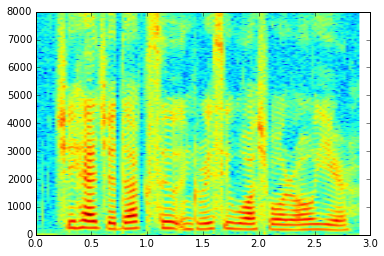

(257, 121)

In [32]:
print(filesTrain[0],", male/female: {0}".format(fileTargetsTrain[0]))
[framerate,sound]=wavfile.read(filesTrain[0])
(spectrum, freqs, t, im)=specgram(sound,NFFT=512,Fs=16000)
plt.show()
wavPlayer(filesTrain[0])
np.shape(spectrum)

In [37]:
def buildCnn(input_var=None):
    print("building cnn")
    #input
    network = lasagne.layers.InputLayer(shape=(None, 1, 129, 150),
                                        input_var=input_var)
    print("shape 1st: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #conv
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(129, 8),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform("relu"))
    print("shape 2st: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #max pool
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(1, 4))
    print("shape 3rd: {0}".format(lasagne.layers.get_output_shape(network)))
    #network = lasagne.layers.ReshapeLayer(network,(-1,1,32,13))
    #lag for lag
    #conv
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(1, 8),
            nonlinearity=lasagne.nonlinearities.rectify
            ,W=lasagne.init.GlorotUniform("relu"))
    print("shape 4th: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #max pool
    network = lasagne.layers.MaxPool2DLayer(
            network, pool_size=(1, 4))
    print("shape 5th: {0}".format(lasagne.layers.get_output_shape(network)))
    
    network = lasagne.layers.DenseLayer(
             lasagne.layers.dropout(network, p=.0), num_units=100,
            nonlinearity=lasagne.nonlinearities.rectify
            ,W=lasagne.init.GlorotUniform("relu"))
    print("shape 7th: {0}".format(lasagne.layers.get_output_shape(network)))
    #dense
    
    out = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.0), num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid
            ,W=lasagne.init.GlorotUniform())
    print("shape 8th: {0}".format(lasagne.layers.get_output_shape(out)))
    return out

In [38]:
print("setting up model")
input_var = T.tensor4('inputs')
target_var = T.imatrix('targets')
network=buildCnn(input_var)
print("\tbuilding prediction/loss")
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.binary_crossentropy(prediction, target_var)
loss = loss.mean()
print("\tbuilding params/updates")
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.001, momentum=0.9)
print("\tbuilding test prediction/loss")
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.binary_crossentropy(test_prediction,target_var)
print("\tbuilding test loss/acc")
test_loss = test_loss.mean()
binaryPrediction = test_prediction > .5
test_acc = T.mean(T.eq(binaryPrediction, target_var.T))
#test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
#                      dtype=theano.config.floatX)
print("\tbuilding train/val functions")
train_fn = theano.function([input_var, target_var], loss, updates=updates)
val_fn = theano.function([input_var, target_var], test_loss)
predict_fn = theano.function([input_var],test_prediction)
print("\ndone")

setting up model
building cnn
shape 1st: (None, 1, 129, 150)
shape 2st: (None, 32, 1, 143)
shape 3rd: (None, 32, 1, 35)
shape 4th: (None, 32, 1, 28)
shape 5th: (None, 32, 1, 7)
shape 7th: (None, 100)
shape 8th: (None, 1)
	building prediction/loss
	building params/updates
	building test prediction/loss
	building test loss/acc
	building train/val functions

done


In [35]:
print("percentage of men: {0}".format(sum(y/len(y))))
print("percentage of men: {0}".format(sum(y_val/len(y_val))))

percentage of men: [ 0.70562771]
percentage of men: [ 0.66666667]


In [39]:
print("training!")
numEpochs=30
trainError = np.empty(numEpochs)
valError   = np.empty(numEpochs)
for epoch in range(numEpochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, 10, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)

            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 50, shuffle=False):
            inputs, targets = batch
            err = val_fn(inputs, targets)
            val_err += err
            val_batches += 1

        # Then we print the results for this epoch:
        trainError[epoch]=train_err/train_batches
        valError[epoch] = val_err / val_batches
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, numEpochs, time.time() - start_time))

        print("  training loss:\t\t{:.6f}".format(trainError[epoch]))
        print("  validation loss:\t\t{:.6f}".format(valError[epoch]))
print("done")

training!
Epoch 1 of 30 took 45.407s
  training loss:		0.616316
  validation loss:		0.638146
Epoch 2 of 30 took 44.308s
  training loss:		0.605037
  validation loss:		0.635936
Epoch 3 of 30 took 42.740s
  training loss:		0.603967
  validation loss:		0.634930
Epoch 4 of 30 took 42.551s
  training loss:		0.601674
  validation loss:		0.631410
Epoch 5 of 30 took 42.245s
  training loss:		0.598499
  validation loss:		0.628414
Epoch 6 of 30 took 42.483s
  training loss:		0.593429
  validation loss:		0.617415
Epoch 7 of 30 took 42.389s
  training loss:		0.582892
  validation loss:		0.604599
Epoch 8 of 30 took 42.320s
  training loss:		0.566995
  validation loss:		0.578916
Epoch 9 of 30 took 42.342s
  training loss:		0.541636
  validation loss:		0.568964
Epoch 10 of 30 took 42.700s
  training loss:		0.516718
  validation loss:		0.521478
Epoch 11 of 30 took 42.486s
  training loss:		0.493781
  validation loss:		0.561166
Epoch 12 of 30 took 42.307s
  training loss:		0.476750
  validation loss:		

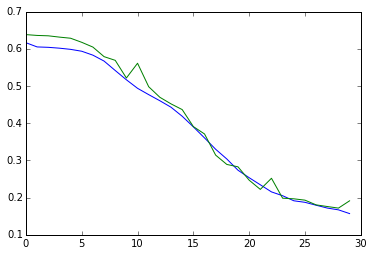

In [40]:
plt.plot(trainError)
plt.plot(valError)

In [41]:
preds=np.equal(predict_fn(X_val)>0.5,y_val)
print(preds.sum()/len(preds))

0.92380952381


In [51]:

X_tree_train=np.reshape(np.ravel(X), (X.shape[0],X.shape[2]*X.shape[3]))
y_tree_train=np.reshape(np.ravel(y), (y.shape[0]))
X_tree_test=np.reshape(np.ravel(X_val), (X_val.shape[0],X_val.shape[2]*X_val.shape[3]))
y_tree_test=np.reshape(np.ravel(y_val), (y_val.shape[0]))

In [55]:
ert=ExtraTreesClassifier(n_estimators=1000,verbose=1,criterion='entropy',n_jobs=-1)
ert.fit(X_tree_train,y_tree_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [53]:
ert.score(X_tree_test,y_tree_test)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.90535714285714286